# Import libarary

In [4]:
import sys
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings 
warnings.filterwarnings("ignore")

# Import dataset

In [2]:
## Read data
df = pd.read_excel("../data/Cheese.xlsx", sheet_name="Sheet1")
df.head(2)

,ID_juge,Product,Hedonic_category,FreeJAR_description
0,33002,CE,I like it a lot,The taste is good
1,33002,M,I like it moderately,This product is good but the taste is too strong


# Load model Zero-shot NLI 

## If you don't have model, you use directly my model on this folder

In [6]:
# Load the tokenizer and model from the checkpoint
model_path = "../model/fine_tuned_deberta_nli 018"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
print(model.config.id2label)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}


##### Some model using class 0 is entailment and 2 is contradiction, you should focus this infomation

## Or if you want to try another model, you can download via Huggingface

In [ ]:
''' Rename model name from Huggingface and run this code
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
'''

# Start with STEP 1: Prediction

In [9]:
hedonic_labels =  ["I don't like it", 'I like it moderately', 'I like it a lot']
hypotheses1 = [f"The consumer of this product said {label}." for label in hedonic_labels]
results1 = []
for i in df['FreeJAR_description'].tolist():
    premise = i
    ## premise-hypothesis
    pairs1 = [(premise, hypothesis) for hypothesis in hypotheses1]
    ## Token
    inputs1 = tokenizer(pairs1, padding=True, truncation=True, return_tensors="pt").to(device)
    # Run model to get logits
    with torch.no_grad():
        outputs1 = model(**inputs1)
        logits1 = outputs1.logits
    entailment_probs1 = torch.softmax(logits1, dim=0)[:,0]
    results1.append(entailment_probs1)
df_probs = pd.DataFrame([t.tolist() for t in results1], columns=hedonic_labels)
res = pd.concat([df, df_probs], axis=1)

# Next to STEP 2: Comparison

### Post-processing Predicted Results

To better analyze the model's outputs, we will perform some post-processing steps:

#### 1. Extract the Predicted Label
For each row, we will select the label with the highest predicted probability and assign it to a new column called **"Predict"**.

#### 2. Evaluate Consistency
We will compare the predicted label with the label chosen by the consumer:
- If they match, we consider it **"consistent"**.
- If they differ, we label it as **"inconsistent"**.

In [30]:
res['predict'] = res.iloc[:,-3:].idxmax(axis=1)
res['consistency'] = res.apply(lambda row: 'consistent' if row['Hedonic_category'] == row['predict'] else 'inconsistent', axis=1)

### Model Mistake Evaluation
Basically, when the model's prediction does not match the selected label, we consider it a mistake from the model's perspective. In this context, we define two levels of mistakes:
#### 1. Serious Mistake
This occurs when the model predicts something completely opposite to the actual label — for example, predicting **"I don't like it"** when the true label is **"I like it a lot"**, or vice versa. This indicates a major misjudgment by the model.
#### 2. Non-Serious Mistake
This happens when the model's prediction is only slightly off — for example, predicting **"I like it moderately"** instead of **"I like it a lot"**.

---

### Formal Definition
Consider the labels as ordered categories:
- `0` → "I don't like it"  
- `1` → "I like it moderately"  
- `2` → "I like it a lot"

We define mistake severity based on the **distance between the predicted label index and the true label index**:
- If the difference is `2`: **Severe mistake**
- If the difference is `1`: **Less severe mistake**
- If the difference is `0`: ✅ **Correct prediction**

In [32]:
res["mistake"] = res['Hedonic_category'] != res['predict']
res["serious_mistake"] = ((res['Hedonic_category'] == "I don't like it") & (res['predict'] == "I like it a lot")) | ((res['Hedonic_category'] == "I like it a lot") & (res['predict'] == "I don't like it"))
res["nonserious_mistake"] = ((res['Hedonic_category'] == "I like it moderately") & ((res['predict'] == "I like it a lot") | (res['predict'] == "I don't like it")))

### Now we have dataframe look like

In [33]:
res.head()

,ID_juge,Product,Hedonic_category,FreeJAR_description,I don't like it,I like it moderately,I like it a lot,predict,consistency,mistake,serious_mistake,nonserious_mistake
0,33002,CE,I like it a lot,The taste is good,0.053914,0.364531,0.581555,I like it a lot,consistent,False,False,False
1,33002,M,I like it moderately,This product is good but the taste is too strong,0.295306,0.430168,0.274526,I like it moderately,consistent,False,False,False
2,33002,B,I like it moderately,This product is good but the taste is a bit st...,0.232817,0.446118,0.321064,I like it moderately,consistent,False,False,False
3,33002,R,I like it moderately,This product is good but the texture is a litt...,0.265007,0.382502,0.352491,I like it moderately,consistent,False,False,False
4,33002,C,I like it a lot,The taste is good but the texture is a bit str...,0.195967,0.474808,0.329226,I like it moderately,inconsistent,True,False,False


# Assess consistency of the data
## Global consistency

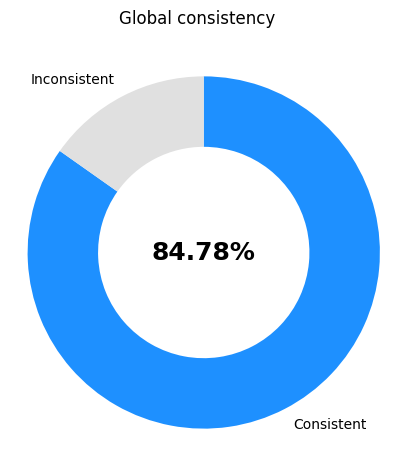

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
consistent_value = res['consistency'].value_counts()['consistent']*100/len(res)
sizes = [consistent_value, 100-consistent_value]
colors = ['#1E90FF', '#E0E0E0']  # màu chính và màu nền
labels = ['Consistent', 'Inconsistent']
ax.pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
ax.text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
fig.suptitle("Global consistency")
plt.axis('equal')  # make sure that circle
plt.show()

## Class-level consistency

#### Confusion matrix

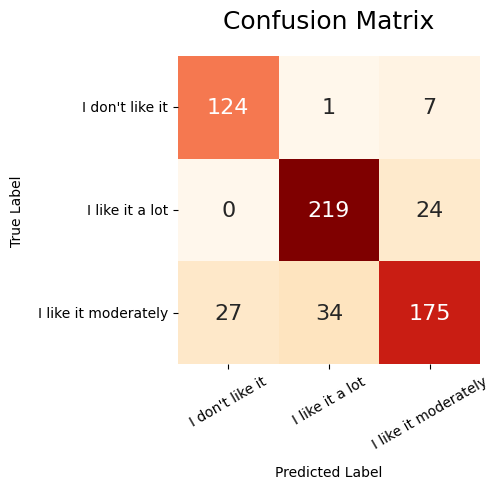

In [35]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(hedonic_labels) ### Make sure that x-axis and y-axis have same order like Hedonic labels
categories_encoded = label_encoder.transform(res['Hedonic_category'])
original_classes = list(label_encoder.classes_)

swapped_classes = [original_classes[0], original_classes[2], original_classes[1]]
# Create confusion matrix
cm = confusion_matrix(res['Hedonic_category'], res['predict'], labels=swapped_classes)
# Create a more visually appealing plot
plt.figure(figsize=(5,5))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='OrRd',
            xticklabels=swapped_classes,
            yticklabels=swapped_classes, cbar=False,
            annot_kws={"size": 16})
plt.title('Confusion Matrix', pad=20, fontsize=18)
plt.xlabel('Predicted Label', labelpad=10, fontsize=10)
plt.ylabel('True Label', labelpad=10, fontsize=10)
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Plot consistency per each class

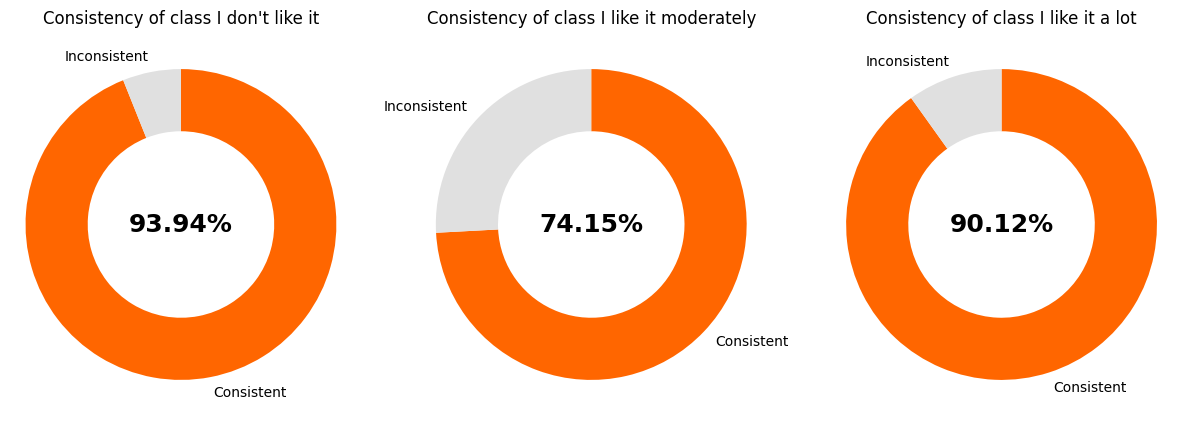

In [36]:
colors = ['#FF6600', '#E0E0E0']  # change color in here
labels = ['Consistent', 'Inconsistent']
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
## I don't like it
res_temp = res[res['Hedonic_category'] == "I don't like it"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[0].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[0].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[0].set_title("Consistency of class I don't like it")
axs[0].axis('equal')  # make sure the circle is not distorted
## I like it moderately
res_temp = res[res['Hedonic_category'] == "I like it moderately"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[1].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[1].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[1].set_title("Consistency of class I like it moderately")
axs[1].axis('equal')  # make sure the circle is not distorted
## I like it a lot
res_temp = res[res['Hedonic_category'] == "I like it a lot"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[2].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[2].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[2].set_title("Consistency of class I like it a lot")
axs[2].axis('equal')  # make sure the circle is not distorted
plt.show()

## Jugde-level consistency

In [38]:
res.head(2)

,ID_juge,Product,Hedonic_category,FreeJAR_description,I don't like it,I like it moderately,I like it a lot,predict,consistency,mistake,serious_mistake,nonserious_mistake
0,33002,CE,I like it a lot,The taste is good,0.053914,0.364531,0.581555,I like it a lot,consistent,False,False,False
1,33002,M,I like it moderately,This product is good but the taste is too strong,0.295306,0.430168,0.274526,I like it moderately,consistent,False,False,False


In [40]:
mistake_summary = res.groupby('ID_juge')[['mistake', 'serious_mistake']].sum().reset_index()
serious_mistake_count = mistake_summary.groupby('mistake')['serious_mistake'].sum().reindex(range(0, mistake_summary['mistake'].max() + 1), fill_value=0)
mistake_count = mistake_summary['mistake'].value_counts().reindex(range(0, mistake_summary['mistake'].max() + 1), fill_value=0)
nonserious_mistake_count = mistake_count - serious_mistake_count

#### In this case, we set the threshold is 4, which is half of the number of product

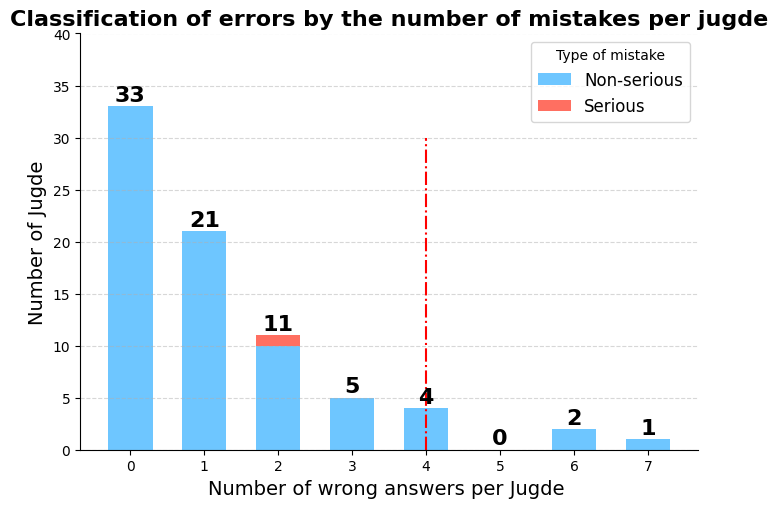

In [42]:
wrong_predict = np.array(mistake_count.index)
weight_counts = {
    "Non-serious": np.array(nonserious_mistake_count),
    "Serious": np.array(serious_mistake_count),
}
colors = {
    "Non-serious": "#6EC6FF",        
    "Serious": "#FF6F61",  
}
width = 0.6
fig, ax = plt.subplots(figsize=(7, 5))
# stacking
bottom = np.zeros(len(wrong_predict))
for label, weight_count in weight_counts.items():
    ax.bar(wrong_predict, weight_count, width, label=label, bottom=bottom, color=colors[label])
    bottom += weight_count
ax.vlines(x=4, ymin=0, ymax=30, linestyles="dashdot", colors="red") 
ax.set_xlabel("Number of wrong answers per Jugde ", fontsize=14)
ax.set_ylabel("Number of Jugde", fontsize=14)
ax.legend(title="Type of mistake", fontsize=12)
ax.set_xticks(wrong_predict)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_ylim(0,40)
for i, v in enumerate(mistake_count):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=16, fontweight='bold')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.title("Classification of errors by the number of mistakes per jugde", fontsize=16, fontweight='bold')
plt.show()


## Jugde-Product level Consistency

### Consistency Analysis: Panelists and Products

Inspired by the *panel performance* functionality in the **SensomineR** package, we adopt a similar approach to assess how consistently individual testers (panelists) evaluate products, note that from the perspective of a predictive model.

In this analysis, we take a slightly different approach compared to the previous section.

Instead of using the **highest predicted label** (i.e., the label with the highest probability), we focus on the **model's confidence in the label actually selected by the tester**.

That is, for each prediction, we extract the probability assigned by the model to the label that the human tester chose — regardless of whether it was the top prediction or not.

#### Objectives of This Analysis

- **Identify Consistent vs. Inconsistent Testers**  
  We aim to evaluate the level of agreement between the model's predictions and each tester's selected label. This allows us to identify:
  - **Consistent individuals**, whose responses align well with the model.
  - **Inconsistent individuals**, whose evaluations frequently differ from the model’s predictions.

- **Assess Product-Level Consistency**  
  We also apply this analysis at the product level. Specifically, we examine:
  - Which products tend to yield **high agreement** between model predictions and tester labels (i.e., easier to evaluate consistently).
  - Which products result in **high disagreement**, indicating that they may be more subjective or polarizing among testers.

This two-layered analysis helps us understand not only the reliability of individual testers, but also which products provoke more diverse or inconsistent evaluations—insightful for both product development and panel management.


In [43]:
def get_prob_chosen(row):
    return row[f"{row['Hedonic_category']}"]
res["prob_chosen"] = res.apply(get_prob_chosen, axis=1)

In [44]:
pivot = res.groupby(["ID_juge", "Product"])["prob_chosen"].mean().unstack()
pivot["Median"] = pivot.median(axis=1)
median_row = pivot.median(axis=0)
median_row.name = "Median"
pivot_with_median = pd.concat([pivot, median_row.to_frame().T])
sorted_cols = pivot_with_median.loc["Median"].sort_values(ascending=False).index
sorted_rows = pivot_with_median["Median"].sort_values(ascending=False).index
sorted_df = pivot_with_median.loc[sorted_rows, sorted_cols]

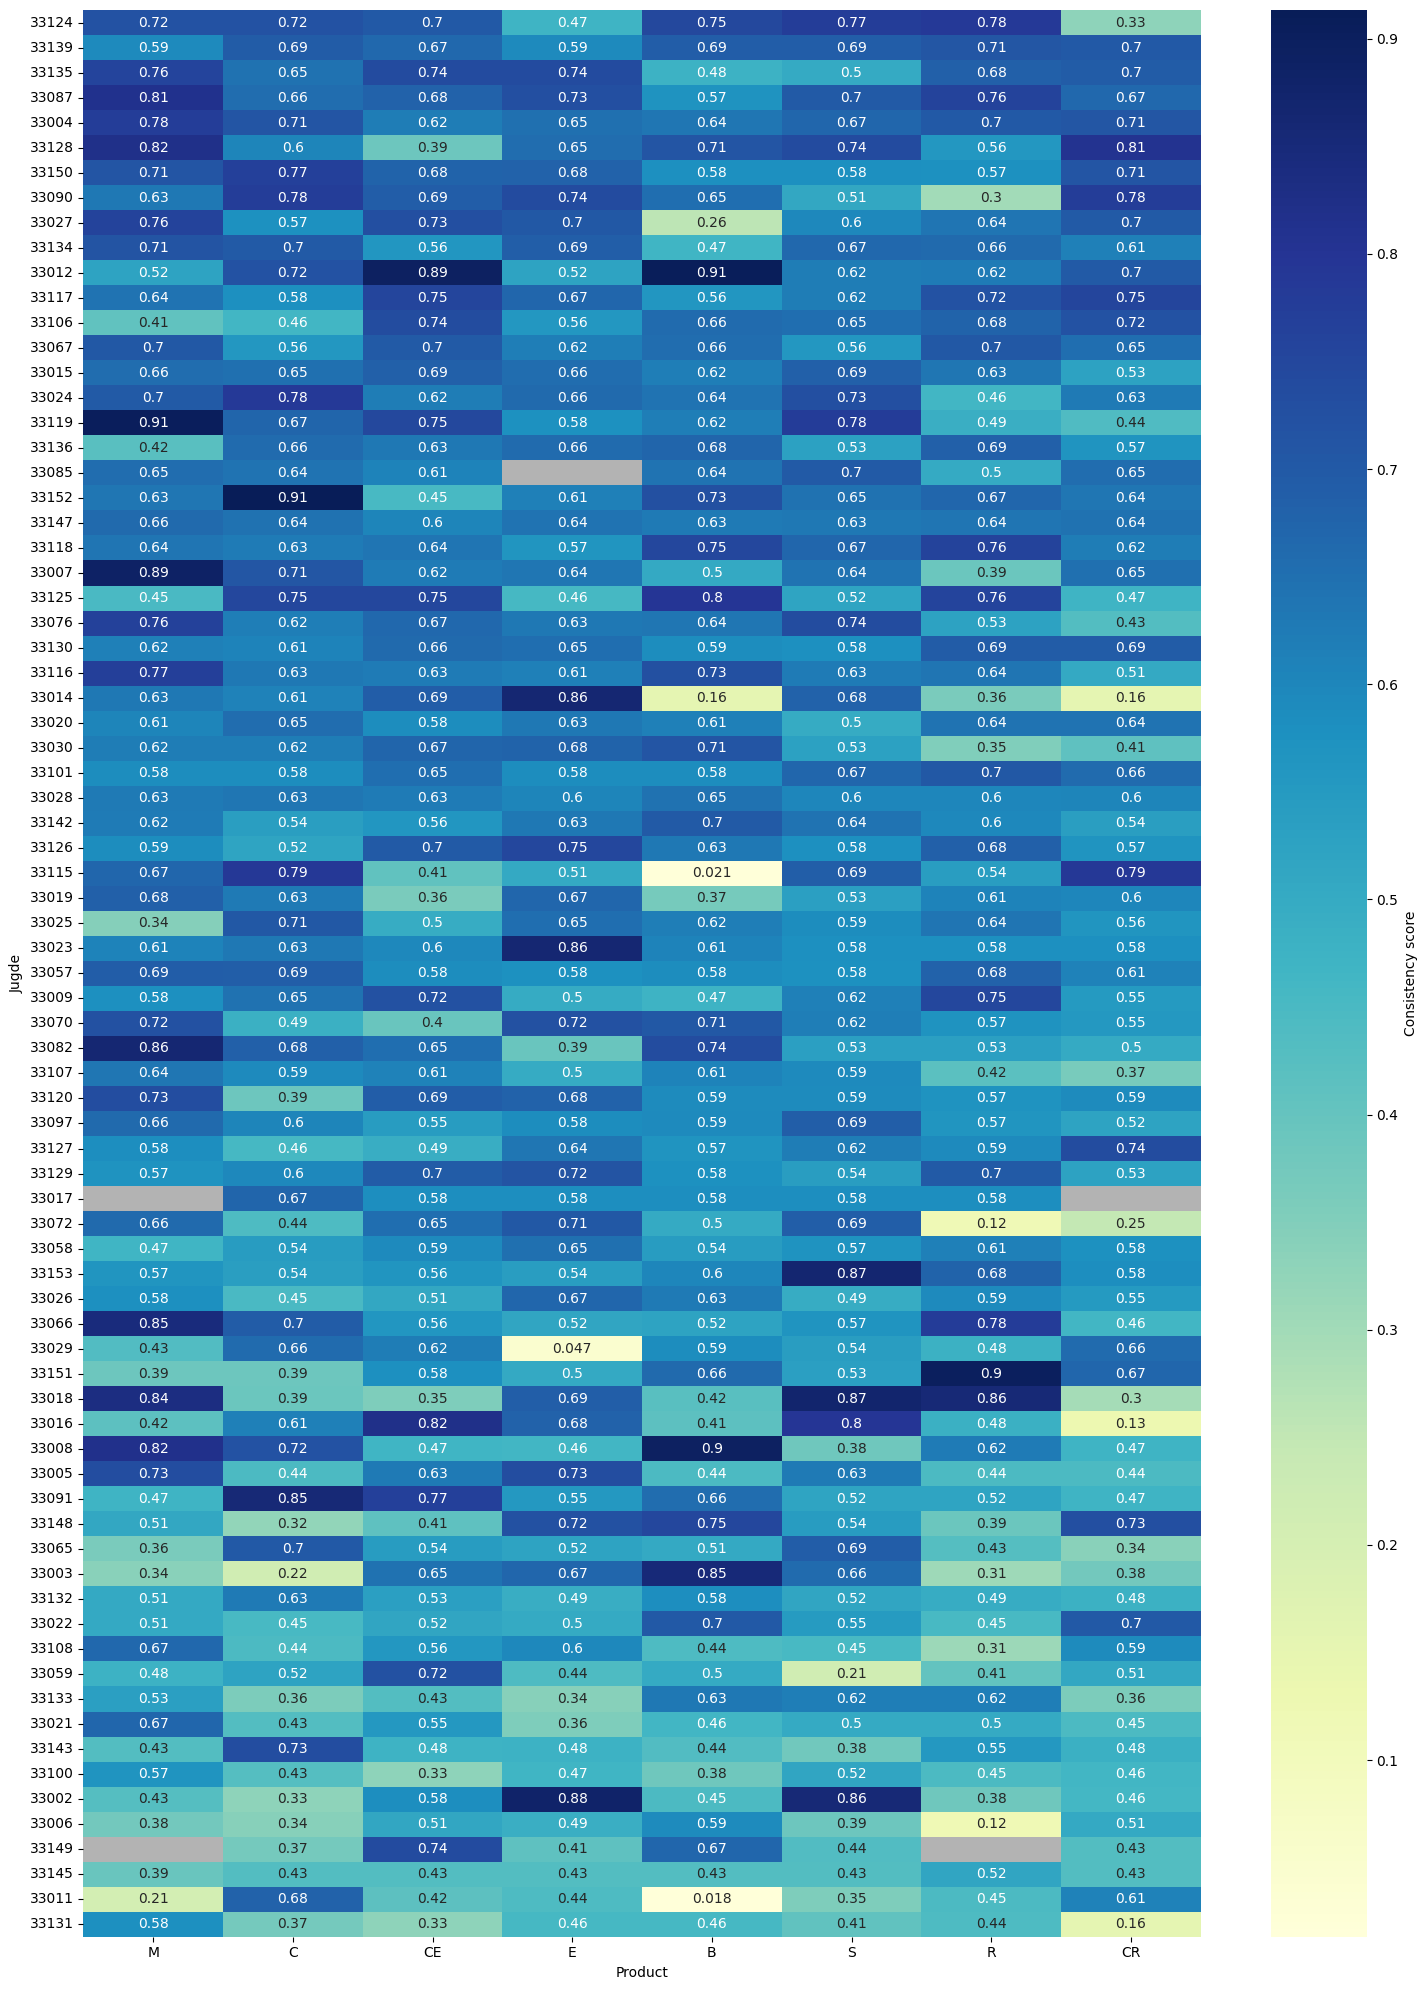

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,20))
ax = sns.heatmap(sorted_df.drop(columns="Median", index="Median"), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Consistency score'}, )
ax.collections[0].cmap.set_bad('0.7')
plt.xlabel("Product")
plt.ylabel("Jugde")
plt.tight_layout()
plt.show()
